In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

print('Data imported and copied.', flush=True)

Data imported and copied.


In [2]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

period = 60
trend_period = 14
rsi_period = 14
num_features = 1
input_period = 60
output_step = 7
units = 512

In [3]:
data.shape

(3524, 6)

In [4]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

In [5]:
X[-5:]

array([[5991.08007812, 5973.60986328, 5934.91015625, 5932.31982422,
        5867.35009766, 5881.33984375, 5937.79003906, 5933.06982422,
        5979.29980469, 5981.91992188, 5995.06005859, 5998.83984375,
        6057.14013672, 6064.56982422, 6058.52978516, 6063.52001953,
        6081.25      , 6069.99023438, 6092.45019531, 6114.52978516,
        6122.60986328, 6114.35009766, 6092.62011719, 6108.81982422,
        6067.83007812, 6080.22021484, 6055.04003906, 6037.87011719,
        6213.47021484, 6227.58984375, 6248.56005859, 6248.64990234,
        6236.39013672, 6295.58007812, 6313.60986328, 6320.77978516,
        6345.81005859, 6312.20996094, 6309.06982422, 6316.18017578,
        6293.64013672, 6258.35986328, 6339.14013672, 6314.50976562,
        6308.60986328, 6378.62988281, 6386.12011719, 6409.29003906,
        6405.97021484, 6422.56005859, 6311.37988281, 6365.56005859,
        6337.87011719, 6263.70019531, 6265.10986328, 6293.04980469,
        6316.27978516, 6344.56982422, 6393.89013

In [6]:
data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [7]:
data_input.shape

(3457, 67)

In [8]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 11  # Window length (must be odd)
polyorder = 2      # Polynomial order

savgol = np.array([ savgol_filter(data_input[i], window_length, polyorder) for i in range(data_input.shape[0]) ])

In [9]:
savgol_cropped = list()

# NO NEED TO CROP
for _savgol in savgol:
    savgol_cropped.append(_savgol)

savgol_cropped = np.array(savgol_cropped)

from sklearn.preprocessing import MinMaxScaler

scaler_savgol = list(MinMaxScaler() for i in range(savgol_cropped.shape[0]))
savgol_scaled = list()

for i in range(savgol_cropped.shape[0]):
    savgol_scaled.append(scaler_savgol[i].fit_transform(savgol_cropped[i].reshape(-1,1)))

savgol_scaled = np.array(savgol_scaled)

X_input = list()
y_input = list()

for savgol in savgol_scaled:
    X_input.append(savgol[:-y.shape[1]])
    y_input.append(savgol[-y.shape[1]:])

X_input = np.array(X_input)
y_input = np.array(y_input)

In [62]:
X_input[0].shape, input_period, units, y_input.reshape(-1,7).shape

((60, 1), 60, 512, (3457, 7))

In [71]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build LSTM model
model = Sequential([
    Bidirectional(LSTM(units, input_shape=(input_period, num_features))),
    #Flatten(),
    Dense(output_step)
])

# Compile the pipeline model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='model_weights_7-online-learning/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [72]:
X_input[-5:].shape, y_input[-5:].shape

((5, 60, 1), (5, 7, 1))

In [73]:
y_input.reshape(-1,7)[-5:]

array([[0.87241819, 0.91076813, 0.93801251, 0.9605579 , 0.97840427,
        0.99155164, 1.        ],
       [0.92389286, 0.95592497, 0.97658998, 0.99082415, 0.99862749,
        1.        , 0.99494167],
       [0.96036765, 0.98798816, 0.99854218, 1.        , 0.99236163,
        0.97562706, 0.94979631],
       [0.97565977, 0.99635808, 1.        , 0.99204464, 0.972492  ,
        0.94134208, 0.89859488],
       [0.99780919, 1.        , 0.99822136, 0.98663752, 0.96524846,
        0.9340542 , 0.89305473]])

In [75]:
import time

start = time.time()

# Train the pipeline model
history = model.fit(X_input[-5:], y_input.reshape(-1,7)[-5:], epochs=150, validation_split=0.2, callbacks=[checkpoint, early_stopping])

end = time.time() - start
print(f'Duration in sec: {end}')

Epoch 1/150
1/1 [==============================] - 2s 2s/step - loss: 0.0694 - accuracy: 0.2500 - val_loss: 0.0486 - val_accuracy: 0.0000e+00
Epoch 2/150
1/1 [==============================] - 1s 878ms/step - loss: 0.0422 - accuracy: 0.0000e+00 - val_loss: 0.0186 - val_accuracy: 0.0000e+00
Epoch 3/150
1/1 [==============================] - 1s 920ms/step - loss: 0.0163 - accuracy: 0.0000e+00 - val_loss: 0.0127 - val_accuracy: 0.0000e+00
Epoch 4/150
1/1 [==============================] - 1s 939ms/step - loss: 0.0137 - accuracy: 0.0000e+00 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 5/150
1/1 [==============================] - 1s 846ms/step - loss: 0.0242 - accuracy: 0.0000e+00 - val_loss: 0.0283 - val_accuracy: 0.0000e+00
Epoch 6/150
1/1 [==============================] - 1s 835ms/step - loss: 0.0312 - accuracy: 0.2500 - val_loss: 0.0259 - val_accuracy: 0.0000e+00
Epoch 7/150
1/1 [==============================] - 1s 806ms/step - loss: 0.0282 - accuracy: 0.2500 - val_loss: 0.0178

In [76]:
data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [77]:
data_backup.shape

(5033, 6)

In [78]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [79]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 17  # Window length (must be odd)
polyorder = 1      # Polynomial order

data_savgol_test = savgol_filter(X_test, window_length, polyorder)

In [80]:
savgol_cropped_test = list()

# NO NEED TO CROP
for _savgol in data_savgol_test:
    savgol_cropped_test.append(_savgol)

savgol_cropped_test = np.array(savgol_cropped_test)

from sklearn.preprocessing import MinMaxScaler

scaler_savgol_test = list(MinMaxScaler() for i in range(savgol_cropped_test.shape[0]))
savgol_scaled_test = list()

for i in range(savgol_cropped_test.shape[0]):
    savgol_scaled_test.append(scaler_savgol_test[i].fit_transform(savgol_cropped_test[i].reshape(-1,1)))

savgol_scaled_test = np.array(savgol_scaled_test)

X_input_test = list()
#y_input = list()

for savgol in savgol_scaled_test:
    X_input_test.append(savgol)
    #y_input.append(savgol[-y.shape[1]:])

X_input_test = np.array(X_input_test)
#y_input = np.array(y_input)

In [81]:
X_input_test.shape[0], 3524-7

(4966, 3517)

In [83]:
savgol_predictions_test = list()

for j in range(3517, 3517+5):
    if (j+1) % 100 == 0:
        print(j+1)
        
    savgol_predictions_test.append(
        scaler_savgol_test[j].inverse_transform(
            model.predict(X_input_test[j].reshape(savgol_scaled_test[j].shape[1], input_period, num_features), verbose=0)[0].reshape(1,output_step)
        )
    )

savgol_predictions_test = np.array(savgol_predictions_test)

In [84]:
savgol_predictions_test[0][0][0]

7011.992

In [85]:
adjusted_preds = savgol_predictions_test - (savgol_predictions_test[0][0][0] - data_backup['close'].iloc[3517])

In [86]:
adjusted_preds

array([[[6472.48  , 6489.6733, 6495.2646, 6502.007 , 6502.2666,
         6497.6006, 6491.037 ]],

       [[6456.85  , 6472.8853, 6477.7866, 6484.304 , 6485.535 ,
         6480.551 , 6474.336 ]],

       [[6443.847 , 6458.917 , 6463.3525, 6469.5933, 6471.477 ,
         6466.307 , 6460.3057]],

       [[6400.247 , 6412.822 , 6416.261 , 6421.6934, 6424.8604,
         6419.435 , 6414.1533]],

       [[6386.216 , 6400.0405, 6406.3022, 6410.3306, 6412.3784,
         6406.1426, 6398.633 ]]], dtype=float32)

In [87]:
savgol_cropped_test.shape

(4966, 60)

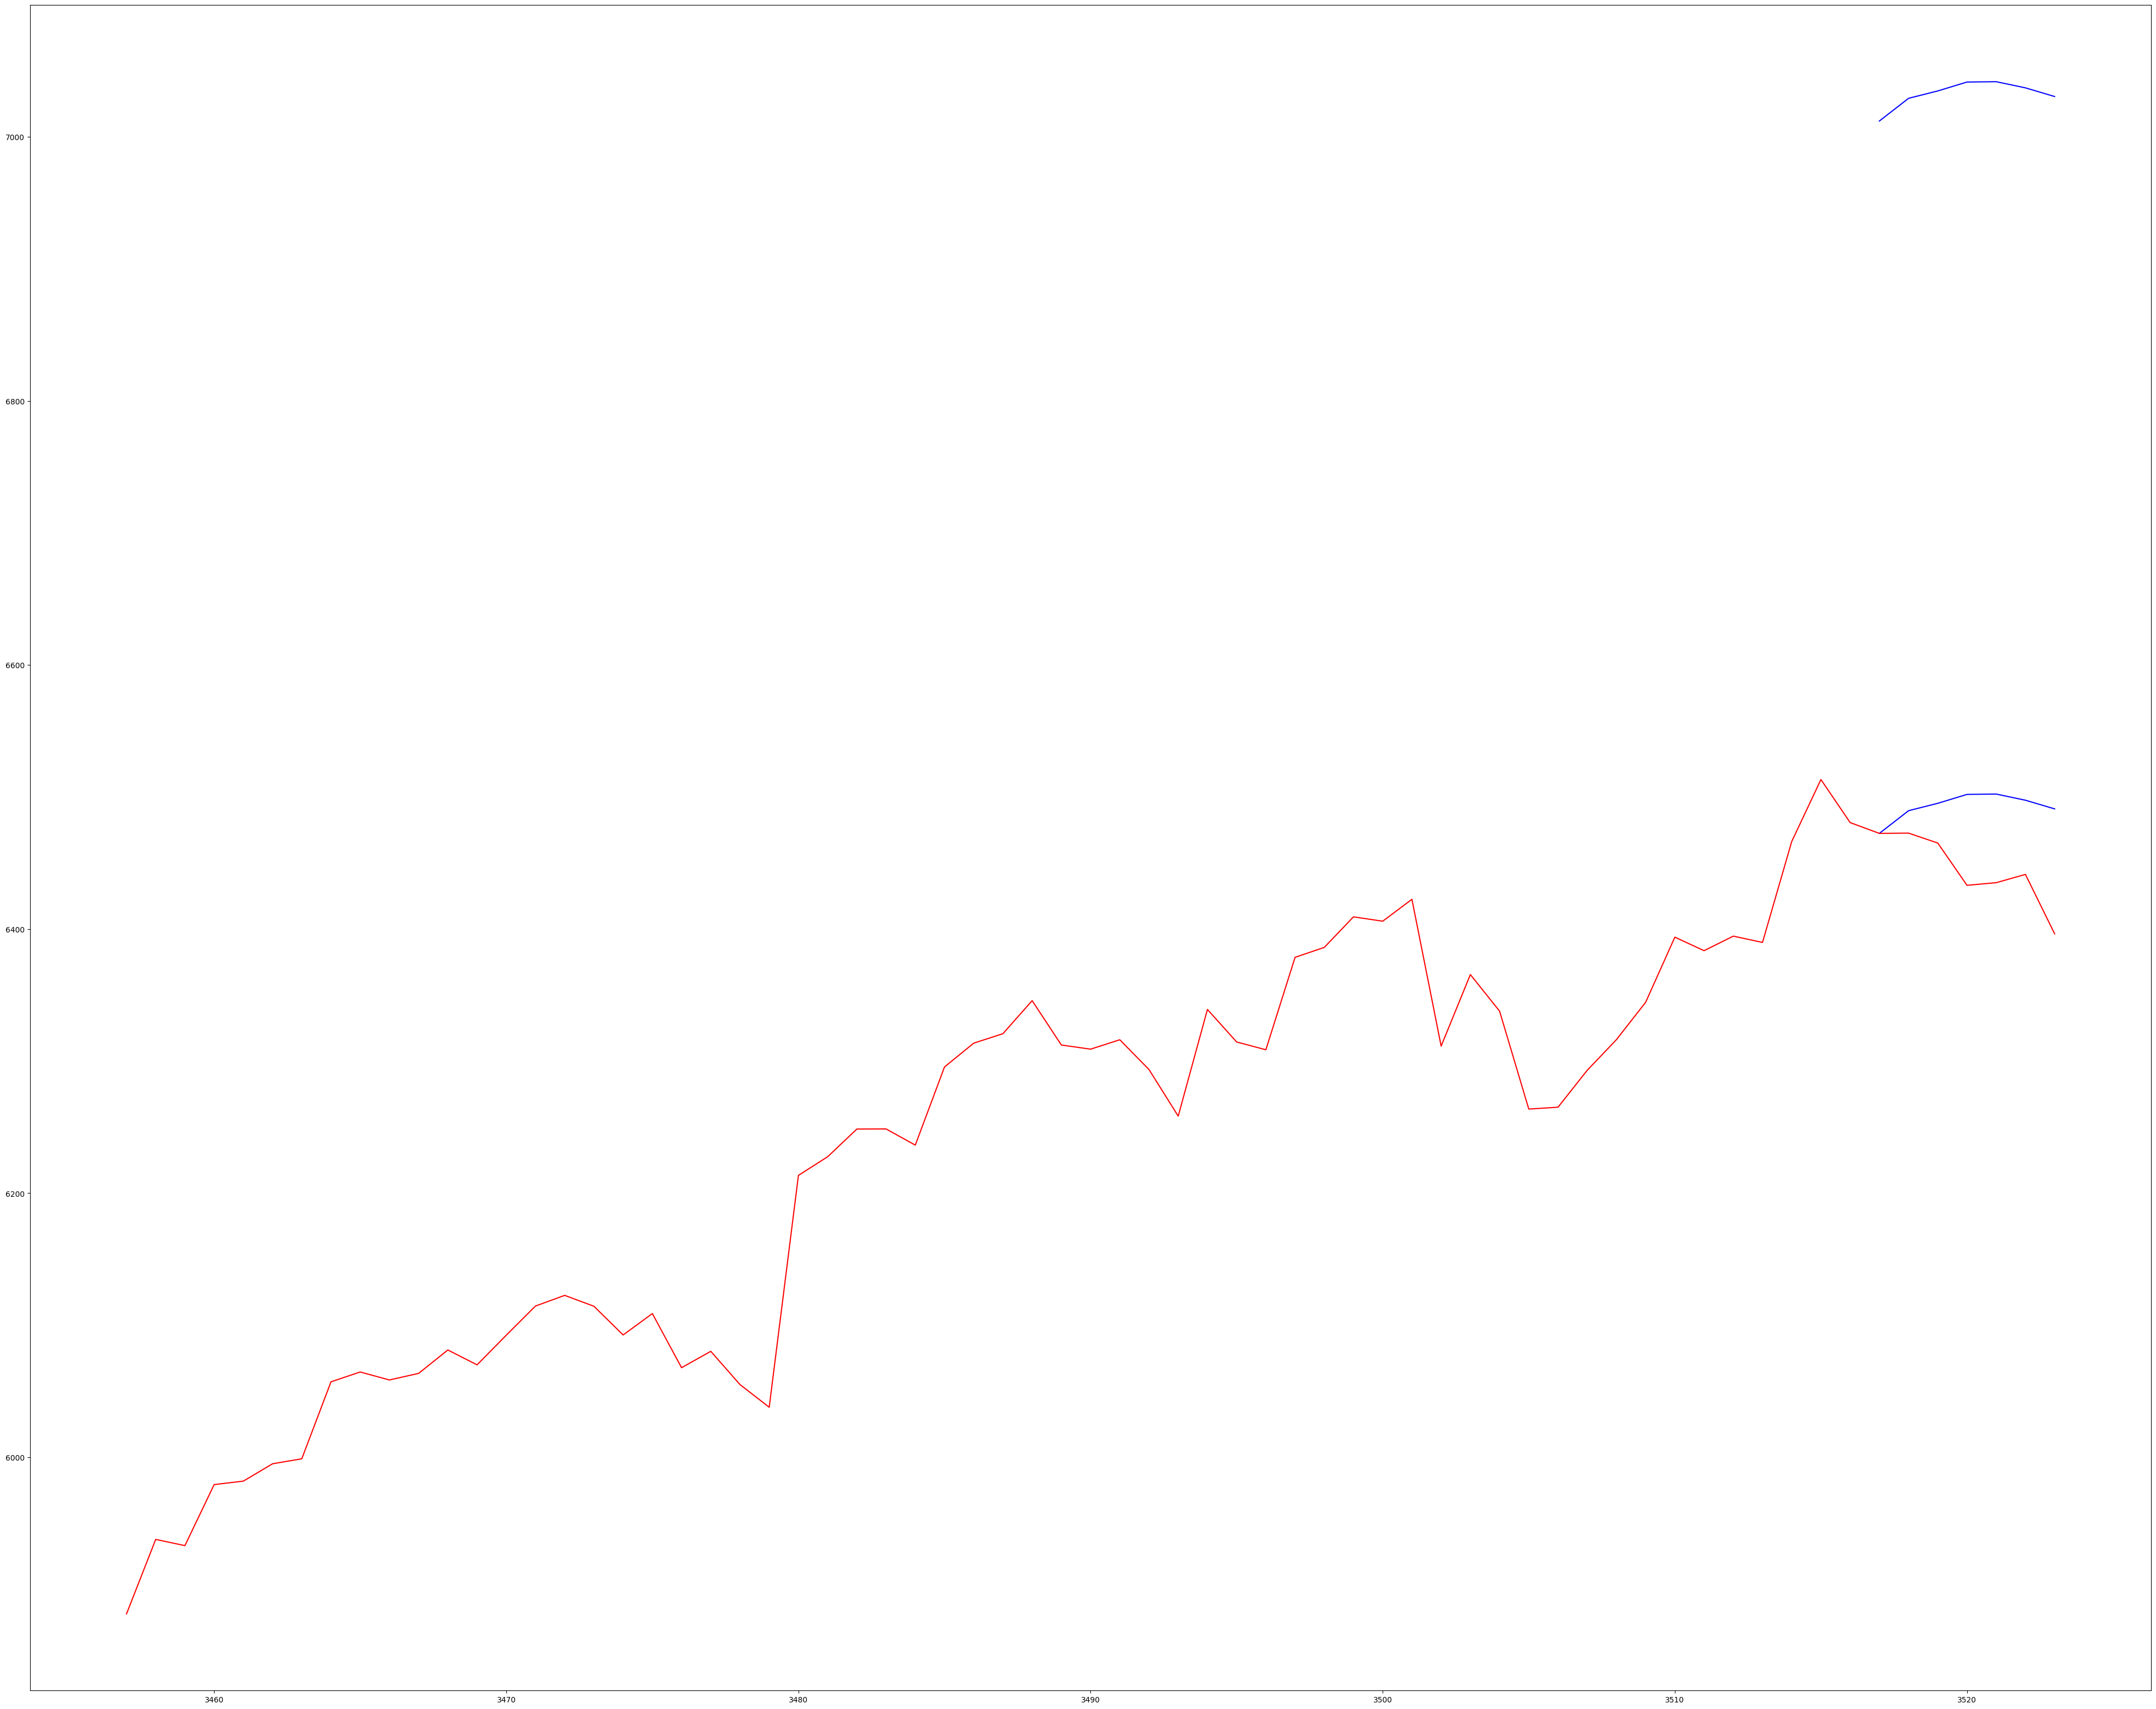

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

t = 0

plt.plot(data_backup.index[t+3517:t+3517+7], savgol_predictions_test[t][0], color='blue')
plt.plot(data_backup.index[t+3517:t+3517+7], adjusted_preds[t][0], color='blue')
#plt.plot(data_backup.index[3517:3517+7], savgol_cropped_test[3517:3517+7], color='black')
plt.plot(data_backup.index[3457:3524], data_backup['close'].iloc[3457:3524], color='red')

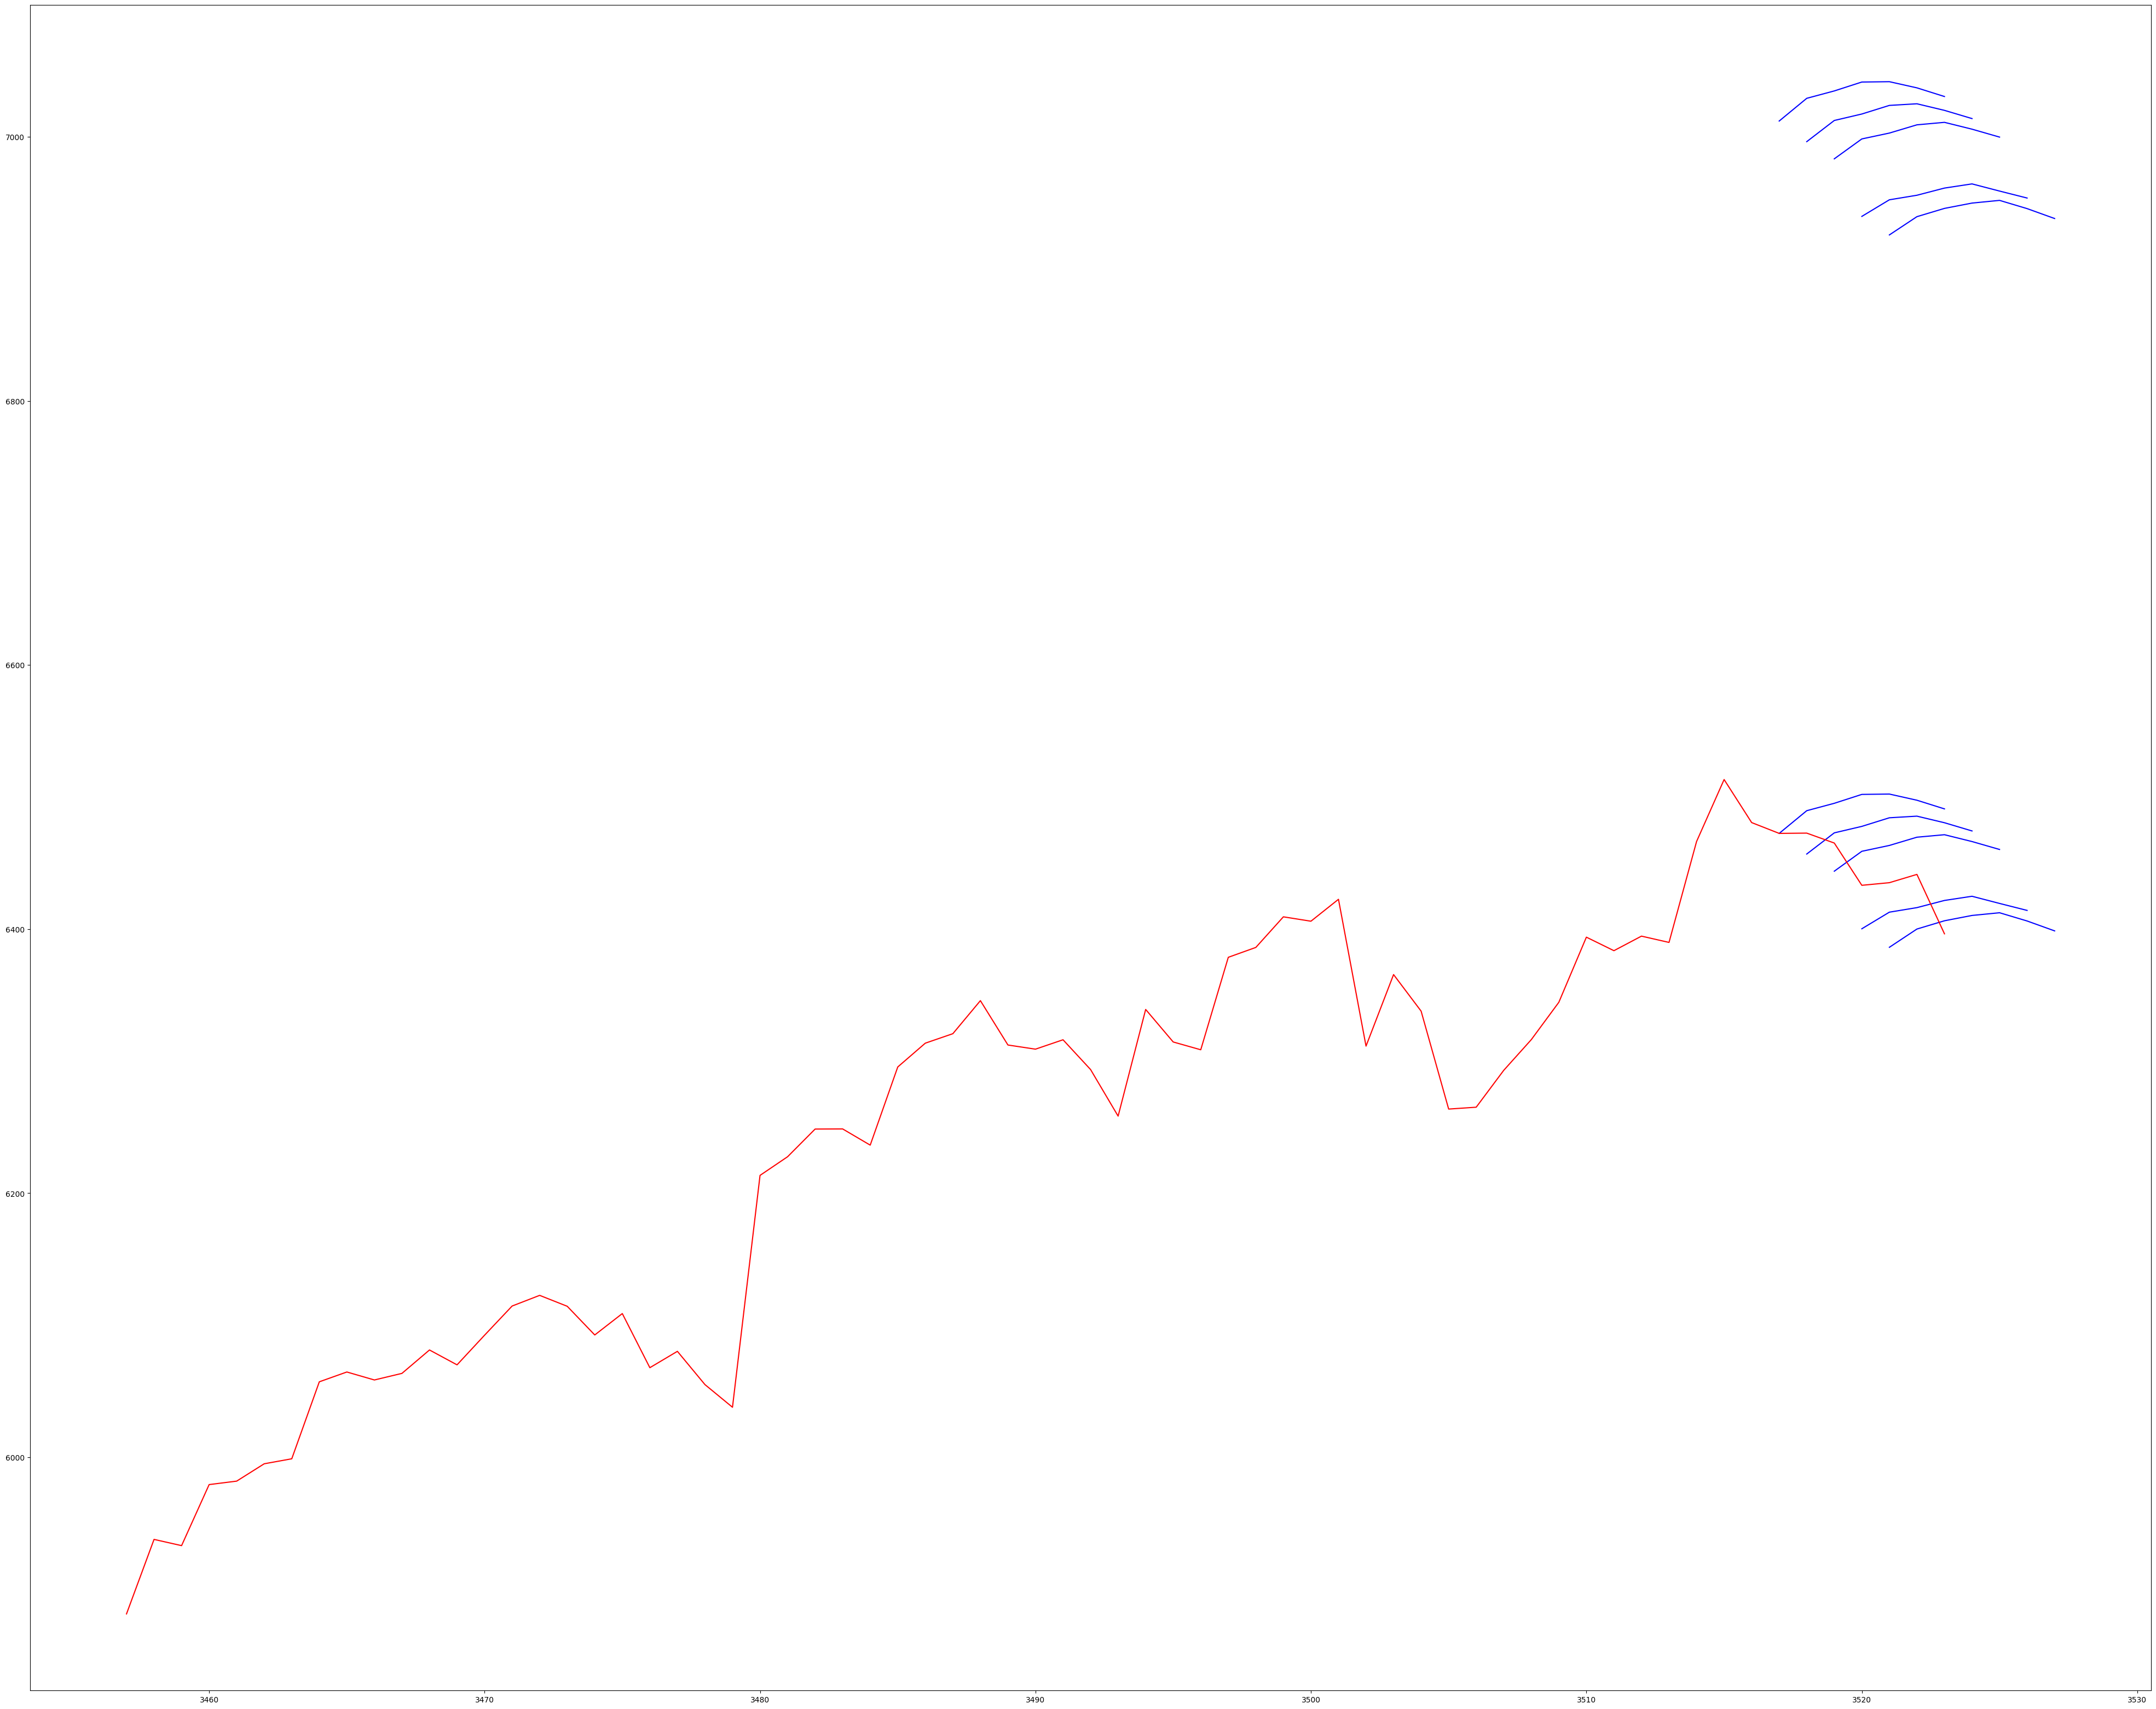

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

for t in range(5):
    plt.plot(data_backup.index[t+3517:t+3517+7], savgol_predictions_test[t][0], color='blue')
    plt.plot(data_backup.index[t+3517:t+3517+7], adjusted_preds[t][0], color='blue')
#plt.plot(data_backup.index[3517:3517+7], savgol_cropped_test[3517:3517+7], color='black')
plt.plot(data_backup.index[3457:3524], data_backup['close'].iloc[3457:3524], color='red')